## Notebook to code up method of moments framework 

Here, I will use the method of moments framework used to track the trajectory of the site frequency spectrum through time given drift and selection from [Jouganous et. al. 2017](https://www.genetics.org/content/206/3/1549). Mostly, I will just use equations to start from a certain generation $t$ back in time and then iterate until generation 0. Then I will store this SFS as a data entry for allele age $t$ and certain selection coefficient $s$. This process will be repeated for each value of $\{1,\ldots,gen,\ldots,12000\}$ generations. 

These vectors need to be summed to marginalize over *all* generations $a$, to give $P(X, a | s)$.

First, need to get a handle on what $\Phi_n^k(i)$ really is - can just be represented as *np.array*

$\phi_n^k(i)$ is the expected number of sites where the alternate allele is observed exactly $i$ times in a sample of size $n$ at generation $k$. 

In [1486]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
from scipy.stats.distributions import chi2
from scipy.sparse import coo_matrix
import moments
import seaborn
from scipy.stats.distributions import chi2
# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})


In [908]:
N = 5000
s = -10/N # 25/N -> gamma = 50 - strong selection
mu = 1.25e-8 # human mutation rate
n = 40 # 2 * # of inds sampled, diploid

# start in generation 10 so generation 11 has all zeros (going back in time)
tot_gen = 10000
time_steps = np.linspace(0, tot_gen-1, 100, dtype=int)

mom = np.zeros((tot_gen+1,n+1))
momnp1 = np.zeros(n+1)
momkp1 = np.zeros((tot_gen+1,n+1))

# double precaution - creating a mask
mk = [False] + [True]*(n-1) + [False]

iter = np.arange(1,n)
iterm1p1 = np.arange(2,n-1)

In [910]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

# The choice i' in n samples that best approximates the frequency of i/(n + 1) is i*n / (n + 1)
def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

In [911]:
# code borrowed from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx  
def calcJK13(n):
    J = np.zeros((n,n-1))
    for i in range(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, ibis - 1] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return J

In [912]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = 1 # singleton input

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:
    momkp1[gen,iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

    momkp1[gen,1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
    momkp1[gen,n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

    # notice the difference in indexing for LHS
    # momnp1[np.arange(1,n+1)] = (jk13[:,0] * mom[gen+1,np.array(ibis)-1] - jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1])
    momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

    momkp1[gen,iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

    mom[gen,] = deepcopy(momkp1[gen,])

mom2 = deepcopy(mom)

In [913]:
## code to run APR's moments and compare with output from above
# initialize the spectrum, with 1 in singleton bin
fs = moments.Spectrum(np.zeros(2*n + 1))
fs[1] = n*1
# simulate a generations
T = tot_gen / 2 / N
# set relative size to 1, theta to 0 to forbid new mutations
fs.integrate([1], T, gamma=s*2*N, h=0.5, theta=0, adapt_dt=True, dt_fac=0.005)

In [914]:
# fs.integrate([1], 0.01*T, gamma=s*2*N, theta=0, h=0.5)
fs = fs.project([n]) * 2

In [915]:
# moments.Spectrum(fsmat[1,:]).project([100])

Text(0, 0.5, 'iterate')

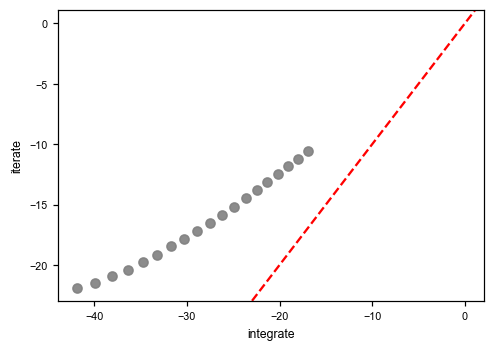

In [916]:
plt.scatter(np.log(np.abs(fs)), np.log(np.abs(mom[0,:])), color='grey', alpha=0.9)
plt.axline((0,0),slope=1,color='red',ls='--'); plt.xlabel('integrate'); plt.ylabel('iterate')

In [918]:
# for dt in 
fsmat = np.zeros((tot_gen,n+1))
for idt, dt in enumerate(np.linspace(1e-3*T,T,tot_gen)[::-1]):
    fs = moments.Spectrum(np.zeros(n + 1))
    fs[1] = n*1
    fs.integrate([1], dt, gamma=0.5*s*2*N, h=0.5, theta=0, adapt_dt=False)
    fsmat[idt,:] = mu*fs

KeyboardInterrupt: 

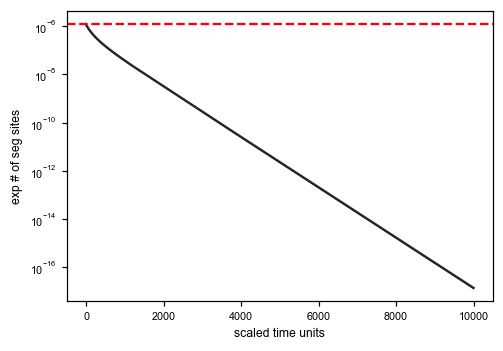

In [ ]:
plt.plot(range(10000)[::-1],np.sum(fsmat[:,1:100],axis=1),color='black',alpha=1)
plt.plot(range(10000)[::-1],np.sum(mom2[1:,1:100],axis=1),color='grey',alpha=0.3)
plt.semilogy(); plt.xlabel('scaled time units'); plt.ylabel('exp # of seg sites')
plt.axhline(n*mu, color='red', ls='--',label='sample scaled mutation rate')

Text(0, 0.5, 'scaled time units')

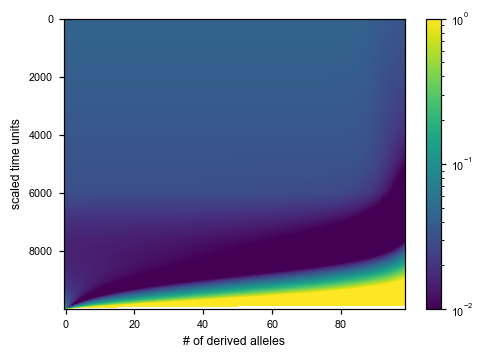

In [ ]:
# np.sum(fsmat[:,1:],axis=1)
plt.imshow(np.abs(fsmat[:-1,1:100]-mom2[:-2,1:100])/mom2[:-2,1:100],aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-2))
# plt.imshow(np.abs(fsmat[:-1,1:100]-mom2[time_steps[:-1],1:100]),norm=colors.LogNorm(vmin=1e-20))
plt.colorbar(); plt.xlabel('# of derived alleles'); plt.ylabel('scaled time units')

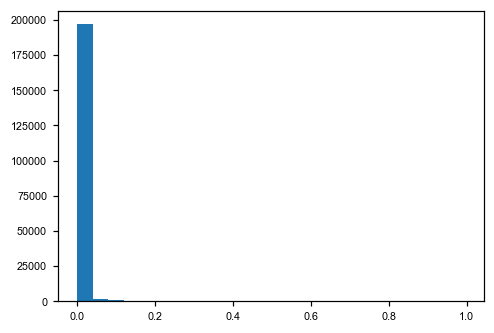

In [1036]:
# np.where(np.max(np.abs(fsmat[:,1:100]-mom2[time_steps,1:100])))
# mom2[time_steps,2]
plt.hist(np.ravel(np.abs(fsmat[:-1,1:100]-mom2[:-2,1:100])),25);

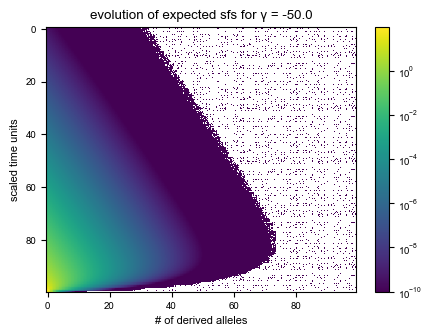

In [ ]:
plt.figure(dpi=100)
plt.imshow((fsmat[-100:,1:]),aspect='auto',norm=colors.LogNorm(vmin=1e-10))
plt.xlabel('# of derived alleles'); plt.ylabel('scaled time units'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()

In [ ]:
S = 0.5 * s * calcS(n+1, J)
D = 0.25/N * calcD(n+1)

In [ ]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = n*1 # singleton input

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:

    momkp1[gen,iter] = mom[gen+1,iter] + ((D[iter,] + S[iter,]) @ mom[gen+1,])
    # momkp1[gen,0] = momkp1[gen,n] = 0.0

    mom[gen,] = deepcopy(momkp1[gen,])

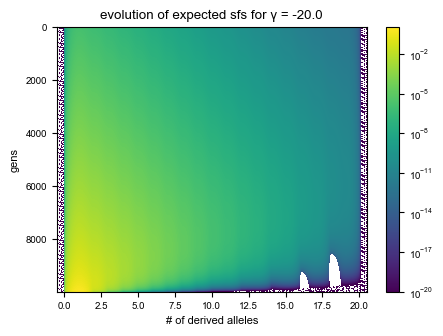

In [1037]:
plt.figure(dpi=100)
plt.imshow((mom2[-10000:,:]),aspect='auto',norm=colors.LogNorm(vmin=1e-20))
plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()

# plt.figure(dpi=100)
# plt.imshow((mom[-10000:,:]),aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-10))
# plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
# plt.colorbar(); plt.show()

# plt.figure(dpi=90)
# plt.scatter(np.arange(tot_gen+1)[::-1][-100000:],(np.sum(mom[-100000:,:],axis=1)),alpha=0.7,color='k')
# plt.loglog(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')
# plt.axhline(n*1, color='red', ls='--',label='sample scaled mutation rate')
# plt.axvline(0.5*N, color='grey',label='N/2'); plt.legend()
# plt.axvline(tot_gen-np.max(np.where(np.sum(mom,axis=1)<0)), color='coral', ls='-.')

In [1043]:
# plt.hist(np.ravel(mom[8000:10000,30:]))
plt.scatter(np.arange(1,n+1),mom[-20000,1:],color='grey',label='iterate')
# plt.plot(np.arange(1,n+1),fs[1:],color='black',label='integrate')
plt.xlabel('# of derived alleles'); plt.ylabel('# of copies')
# plt.scatter(np.ravel(mom),np.ravel(mom2),alpha=0.5,color='grey'); plt.axline((0,0),(1,1),color='red')

IndexError: index -20000 is out of bounds for axis 0 with size 10001

In [ ]:
def calcD(d):
    res = np.zeros([d, d])
    # loop over the fs elements:
    for i in range(d):
        if i > 1:
            res[i, i - 1] = (i-1) * (d-i)
        if i < d - 2:
            res[i, i + 1] = (i+1) * (d-i-2)
        if i > 0 and i < d - 1:
            res[i, i] = -2 * i * (d-i-1)
    return res

In [ ]:
def calcS(d, ljk):
    # Computes the jackknife-transformed selection matrix 1
    # for the addition of a single sample
    # arrays for the creation of the sparse (coo) matrix
    # data will have matrix entry, row + column have coordinates
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        i_bis = index_bis(i, d - 1) # This picks the second jackknife index 
        i_ter = index_bis(i + 1, d - 1) # This picks the third jackknife index
        # coefficients of the selection matrix
        g1 = i * (d-i) / np.float64(d)
        g2 = -(i+1) * (d-1-i) / np.float64(d)

        if i < d - 1 and i > 0: # First deal with non-fixed variants
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                    g1 * ljk[i - 1, i_bis], g2 * ljk[i, i_ter - 1],
                    g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 6 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1,
                    i_ter, i_ter - 1, i_ter + 1]
        
        elif i == 0: # g1=0
            data += [g2 * ljk[i, i_ter - 1],
                     g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 3 * [i]
            col += [i_ter, i_ter - 1, i_ter + 1]
        
        elif i == d - 1: # g2=0
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                     g1 * ljk[i - 1, i_bis]]
            row += 3 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1]

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [1274]:
## packaging into a function for easy manipulation - iteration implementation 
# input: a (number of gens), n (number of samples), s, N (pop size)
# output: mom (number of sites)
def run_mom_iterate(a, n, s, N, mu, misc):
    mom = np.zeros((a+1,n+1))
    momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    J = calcJK13(n)

    iter = np.arange(1,n)
    iterm1p1 = np.arange(2,n-1)

    mom[a,1] = 1 # singleton input

    # going from generation 9 to 0
    for gen in np.arange(a)[::-1]:
        momkp1[iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

        momkp1[1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
        momkp1[n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

        # notice the difference in indexing for LHS
        momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

        momkp1[iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

        mom[gen,] = deepcopy(momkp1)

    return n*mu*mom[:-1,:]           

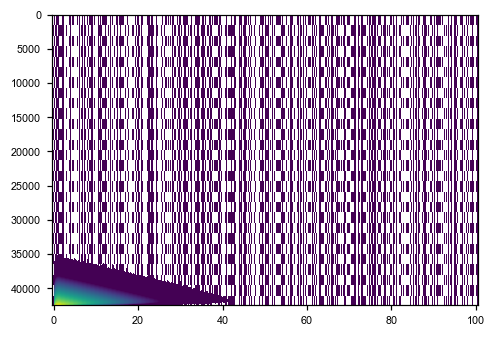

In [1053]:
# fs = run_mom_integrate(2500, 120, -10/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':False})
mom = run_mom_iterate(42500, 100, 0.5*gamma[0]/N, N, mu, np.nan)
plt.imshow((mom),aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30))
# fs.shape, mom.shape
# plt.scatter(mom[-2000,1:-1], fs2[-2000,1:-1], color='grey', alpha=0.75) #plt.loglog()
# plt.axline((0,0),slope=1,color='red',ls='--')

In [ ]:
def run_mom_integrate(a, n, s, N, mu, misc):
    fsmat = np.zeros((a,n+1))
    for idt, dt in enumerate(np.linspace(0.5/N,0.5*a/N,a)[::-1]):
        fs = moments.Spectrum(np.zeros(n + 1))
        fs[1] = n*1
        fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0, dt_fac=misc['dt_fac'], adapt_dt=misc['adapt_dt'])
        fsmat[idt,:] = mu*fs
    return fsmat

In [1423]:
## creating a database of P(X, a | s) with dicts for different s values
# up_xa_s = {}
# gamma = -np.logspace(2,-2,25)
## use different lengths of time for each gamma (high gamma - small limits)
## go up to 5 orders of magnitude below start (i.e., E[# seg sites] < 1e-11)
limal = np.concatenate((np.linspace(7500,100000,15,dtype=int),np.repeat(100000,10)))
for ig, g in enumerate(gamma):
    # unscaled probability - almost likelihood
    up_xa_s[g] = run_mom_iterate(limal[ig], 100, 0.5*g/2500, 2500, mu, np.nan)
    # can project down to any sample size using moments.Spectrum(p_xa_s[g][-1,:]).project([20])*120/20

In [1203]:
up_xa_s[-0.1].shape

(100000, 101)

Text(0, 0.5, 'exp # of seg sites')

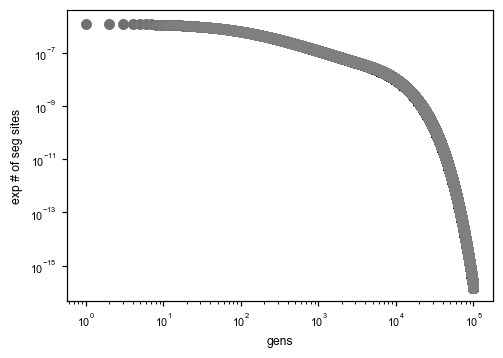

In [1428]:
# use these plots to figure out when to stop (for gamma<1, ok could stop at 10k for high gamma)
plt.scatter(np.arange(1e+5)[::-1],(np.sum(up_xa_s[-.1],axis=1)),alpha=0.7,color='k')
plt.scatter(np.arange(1e+5)[::-1],(np.sum(up_xa_s[-.01],axis=1)),alpha=0.7,color='grey')
plt.loglog(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')

In [1424]:
## scaling the matrix from above to get pdf (all rows sum to 1)
p_xa_s = {}
for g in gamma:
    # normalizing by rows (summing across gens)
    # p_xa_s[g] = up_xa_s[g]/up_xa_s[g].sum(axis=0,keepdims=1)
    # normalizing by rows and cols (summing across gens and # of derived alleles)
    p_xa_s[g] = up_xa_s[g]/np.sum(up_xa_s[g])

In [ ]:
## projecting the moments to a smaller sample size & then scaling (optional)
ss = 20 # small sample
pp_xa_s = {}
for g in gamma:
    pp_xa_s[g] = np.zeros((up_xa_s[g].shape[0],ss))
    for i in range(up_xa_s[g].shape[0]):
        pp_xa_s[g][i,:] = moments.Spectrum(up_xa_s[g][i,:]).project([ss]) * 150/ss
    pp_xa_s[g] = pp_xa_s[g]/pp_xa_s[g].sum(axis=0,keepdims=1)

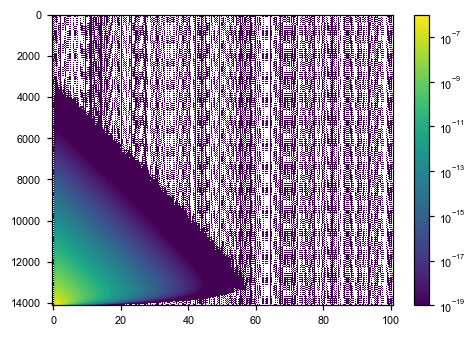

In [1208]:
plt.imshow(up_xa_s[gamma[1]],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-20)); plt.colorbar()

### Reading in simulation data for comparison

In [1061]:
import pandas as pd
df1 = pd.read_csv("traindata/trip-2021-10-20.csv")
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])

In [516]:
## function to obtain the log P(X,|gamma)
def get_lp_xl(g, Xlred, N=2500):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(len(Xlred))

    ub = np.exp(2.*g)*scipy.special.expi(-2.*g*0.25/N) - scipy.special.expi(2.*g*(1-0.25/N)) - np.exp(2.*g)*(np.log(0.25/N) - np.log(1-0.25/N))
    lb = np.exp(2.*g)*scipy.special.expi(2.*g*(0.25/N-1)) - scipy.special.expi(2.*g*0.25/N) - np.exp(2.*g)*(np.log(1-0.25/N) - np.log(0.25/N))
    scalfact = (ub - lb)/np.expm1(2.*g)

    # return a vector...
    for ix, x in enumerate(Xlred):
        res[ix] = (1-np.exp(-2*g*(1-x)))/(x*(1-x)*(1-np.exp(-2*g)))

    return np.log(res/scalfact)

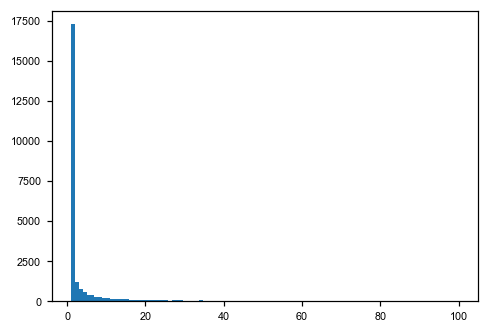

In [1069]:
## don't need a function since the dict already exists
Xsamp = np.arange(1,100+1)/100
plt.hist([np.argmin(np.abs(dat[i,0]-Xsamp))+1 for i in range(len(dat))],bins=100);

In [1354]:
trueg1 = -0.01
trueg2 = gamma[-2]
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3]
# newdf1 = newdf1.sample(frac=1)

newdat = newdf1.loc[newdf1['al']>0,:].to_numpy()

In [1355]:
# plt.hist(newdat[:,2],bins=100)
# plt.hist2d(np.log(newdat[:,0]),newdat[:,2][::-1],(25,25)); plt.colorbar()
print(newdat[-5:,])
get_lp_alxl(-1., newdat[-5:,0], newdat[-5:,2], n=100)

[[ 1.140000e-02 -1.467799e-02  9.100000e+01]
 [ 6.480000e-02 -1.467799e-02  2.410000e+02]
 [ 4.480000e-02 -1.467799e-02  2.484000e+03]
 [ 4.000000e-04 -1.467799e-02  2.100000e+01]
 [ 6.433000e-01 -1.467799e-02  5.335000e+03]]


array([ -7.59454659, -11.47503821, -12.2594201 ,  -7.04358927,
       -15.98280198])

In [1356]:
# plt.plot(p_xa_s[-10.][:,1][::-1]); plt.loglog()
# get_lp_alxl(-1., newdat[-5:,0], newdat[-5:,2], n=100)
get_lp_alxl(gamma[-2], newdat[-5:,0], newdat[-5:,2], n=100)

array([ -7.68820927, -11.55290398, -12.3320414 ,  -7.13940396,
       -15.76019037])

In [1386]:
## just doing a lookup of sorts for the right probability
def get_lp_alxl(g, Xlred, alred, n=120):
    Xsamp = np.arange(1,n)/n
    res = np.empty(len(Xlred))
    for i in range(len(Xlred)):
        # if too many gens, then pass in a very low number
        res[i] = np.log(p_xa_s[g][-int(alred[i]),np.argmin(np.abs(Xlred[i]-Xsamp))+1]) if (int(alred[i]<p_xa_s[g].shape[0])) else -20. 

    return res

-0.01


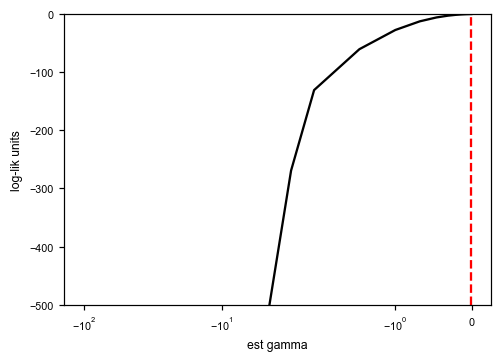

In [1357]:
sin_onlyfreq = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,0]))
plt.plot(gamma,sin_onlyfreq-np.max(sin_onlyfreq),'k'); plt.ylim((-500,0)); plt.xlabel('est gamma'); 
plt.xscale('symlog')
plt.axvline(gamma[np.argmax(sin_onlyfreq)], color='red', linestyle='--'); plt.ylabel('log-lik units')
print(gamma[np.argmax(sin_onlyfreq)])

-4.641589


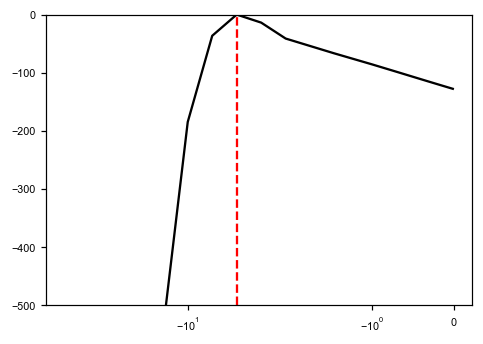

In [1387]:
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,0], newdat[:,2], n=100))

plt.plot(gamma,sin_onlyage-np.nanmax(sin_onlyage),'k'); plt.ylim((-500,0)); plt.xscale('symlog')
plt.axvline(gamma[np.nanargmax(sin_onlyage)], color='red', linestyle='--')
print(gamma[np.nanargmax(sin_onlyage)])

In [1429]:
# newdat[np.isnan(get_lp_alxl(-100., newdat[:,0], newdat[:,2], n=90)),]
sin_onlyage

[nan,
 -15538.908736318928,
 -13527.591940134762,
 -11482.870341886306,
 -10061.693111204688,
 -9150.489796297641,
 -8656.161353886135,
 -8415.511213359385,
 -8314.627680986343,
 -8282.083894644802,
 -8276.866658522882,
 -8279.8811801284,
 -8284.187070998452,
 -8287.847396227455,
 -8290.570489906666,
 -8292.48934365913,
 -8293.820522595901,
 -8294.735386949385,
 -8295.361392747018,
 -8295.788846015474,
 -8296.080418537023,
 -8296.279198557742,
 -8296.41467881663,
 -8296.507002212711,
 -8296.569910477745]

-4.641589


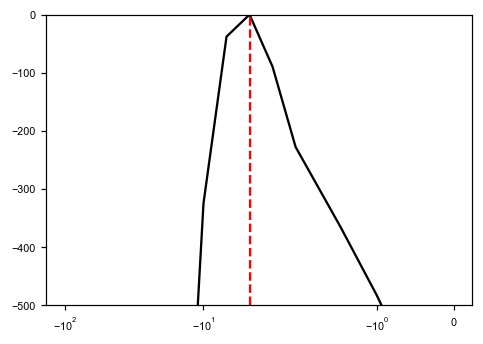

In [1548]:
## assuming only one selection coefficient and both age & freq info
sin_agefreq = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    sin_agefreq[ig] = np.sum(get_lp_alxl(g, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g, newdat[:,0]))

plt.plot(gamma,sin_agefreq-np.nanmax(sin_agefreq),'k'); plt.ylim((-500,0))
plt.xscale('symlog')
plt.axvline(gamma[np.nanargmax(sin_agefreq)], color='red', linestyle='--')
print(gamma[np.nanargmax(sin_agefreq)])

In [1389]:
sin_agefreq

array([            nan, -28148.16475217, -21298.75127156, -16268.55975674,
       -12903.48098813, -10772.8412295 ,  -9466.14290799,  -8691.84352589,
        -8253.68710841,  -8021.62129131,  -7910.59566908,  -7865.47498014,
        -7851.62678334,  -7850.25569339,  -7852.85614635,  -7856.11951977,
        -7858.98405919,  -7861.21247569,  -7862.85210719,  -7864.0232187 ,
        -7864.84542228,  -7865.41663768,  -7865.81085679,  -7866.08175711,
        -7866.26738902])

In [1438]:
preds_sin_onlyfreq = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    newdat = newdf1.loc[newdf1['Xl']>1e-3].to_numpy()
    sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,0], N=2500)) for g1 in gamma]
    preds_sin_onlyfreq[ig] = gamma[np.argmax(sin_onlyfreq)]

In [1439]:
preds_sin_agefreq = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    newdat = newdf1.loc[newdf1['Xl']>1e-3,:].to_numpy()
    # newdat = newdf1.loc[np.logical_and(newdf1['al']>1, newdf1['al']<60),:].to_numpy()
    sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0], N=2500)) for g1 in gamma]
    # sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100)) for g1 in gamma]
    preds_sin_agefreq[ig] = gamma[np.nanargmax(sin_agefreq)]

In [1433]:
preds_sin_onlyage = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    newdat = newdf1.loc[newdf1['Xl']>1e-3,:].to_numpy()
    # newdat = newdf1.loc[np.logical_and(newdf1['al']>1, newdf1['al']<60),:].to_numpy()
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100)) for g1 in gamma]
    preds_sin_onlyage[ig] = gamma[np.nanargmax(sin_onlyage)]

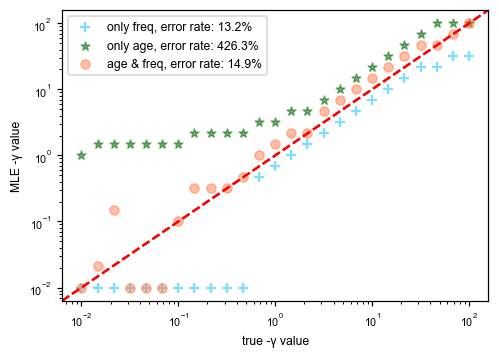

In [1440]:
plt.scatter(-gamma, -preds_sin_onlyfreq, color='deepskyblue', alpha=0.5, label='only freq, error rate: {:.1f}%'.format(np.sum(np.abs(gamma-preds_sin_onlyfreq)/-gamma)), marker='+')
plt.scatter(-gamma, -preds_sin_onlyage, color='darkgreen', alpha=0.5, label='only age, error rate: {:.1f}%'.format(np.sum(np.abs(gamma-preds_sin_onlyage)/-gamma)), marker='*')
plt.scatter(-gamma, -preds_sin_agefreq, color='coral', alpha=0.5, label='age & freq, error rate: {:.1f}%'.format(np.sum(np.abs(gamma-preds_sin_agefreq)/-gamma)))
plt.axline((100,100),(0,0),color='red',ls='--')
plt.xlabel('true -γ value'); plt.ylabel('MLE -γ value'); plt.loglog(); plt.legend()
plt.axline((100,100),(0,0),color='red',ls='--')

In [1419]:
# print(p_xa_s[-10.][-10000,10], p_xa_s[-1.][-10000,10])
sin_onlyage, sin_onlyfreq

([nan,
  -15538.908736318928,
  -13527.591940134762,
  -11482.870341886306,
  -10061.693111204688,
  -9150.489796297641,
  -8656.161353886135,
  -8415.511213359385,
  -8314.627680986343,
  -8282.083894644802,
  -8276.866658522882,
  -8279.8811801284,
  -8284.187070998452,
  -8287.847396227455,
  -8290.570489906666,
  -8292.48934365913,
  -8293.820522595901,
  -8294.735386949385,
  -8295.361392747018,
  -8295.788846015474,
  -8296.080418537023,
  -8296.279198557742,
  -8296.41467881663,
  -8296.507002212711,
  -8296.569910477745],
 array([-18538.34339299, -11632.08153616,  -6951.82480363,  -3786.92779546,
         -1653.54208051,   -222.42257712,    730.2173038 ,   1356.19568615,
          1757.90254523,   2003.79169152,   2142.24408743,   2212.6108429 ,
          2245.61438505,   2260.5091007 ,   2267.19477582,   2270.23339952,
          2271.64325371,   2272.3138077 ,   2272.64180047,   2272.80736404,
          2272.89391113,   2272.9408912 ,   2272.96740007,   2272.9829287 ,
        

In [1243]:
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==gamma[17])),0:3]
newdat = newdf1.loc[newdf1['al']>0,:].to_numpy()
# [np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=90) + get_lp_xl(g1, newdat[:,0])) for g1 in gamma]
[np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100)) for g1 in gamma]

[nan,
 -14945.258801264717,
 -13438.051069235587,
 -12009.145798969526,
 -10967.059478511033,
 -10310.5538577626,
 -9980.85286122299,
 -9850.29309866512,
 -9827.410686006418,
 -9851.339675189643,
 -9886.088196285977,
 -9916.532973567417,
 -9939.32951820076,
 -9955.380361513884,
 -9966.409930997424,
 -9973.909798326087,
 -9979.004974047162,
 -9982.465312036653,
 -9984.816400698219,
 -9986.414795912337,
 -9987.502072071276,
 -9988.241996520039,
 -9988.745704385401,
 -9989.088688687132,
 -9989.322272268002]

In [1656]:
## picking a choice of g1 and g2 & creating a new data frame
trueg1 = gamma[-10]
trueg2 = -100.
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3]#.append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
# newdf1 = newdf1.sample(frac=1)

# only keeping alleles with ages > 1 (cos NN & PRF approx finds really high prob for these alleles to have small gamma...)
newdat = newdf1.loc[newdf1['al']>0,:].to_numpy()

In [1657]:
## assuming two selection coefficients and only freq info (split 50/50)
dub_onlyfreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma[0:(ig1+1)]):
        dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,0], N=2500)) + 0.5*np.exp(get_lp_xl(g2, newdat[:,0], N=2500))))

mask = np.full(dub_onlyfreq.shape,False)
mask[np.triu_indices_from(dub_onlyfreq,k=1)] = True

array([-0.01     , -0.6812921])

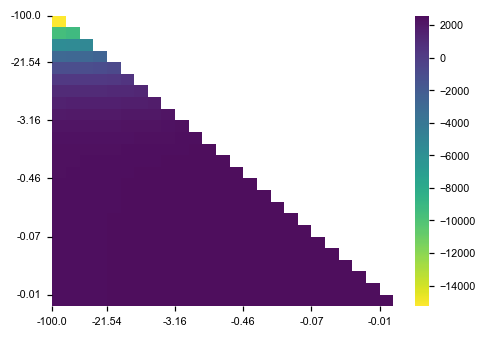

In [1658]:
seaborn.heatmap(dub_onlyfreq,alpha=0.95,cmap='viridis_r',mask=mask, norm=colors.Normalize())
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

In [1659]:
dub_agefreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma[0:(ig1+1)]):
        dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0])) + 0.5*np.exp(get_lp_alxl(g2, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g2, newdat[:,0]))))

In [1660]:
# dub_agefreq[g,1]
# estg1agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[0]]
# estg2agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[1]]
# print(estg1agefreq, estg2agefreq)
# dub_agefreq[~mask][np.nanargmax(dub_agefreq[~mask])]
np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape)

(24, 1)

array([-1.000000e-02, -6.812921e+01])

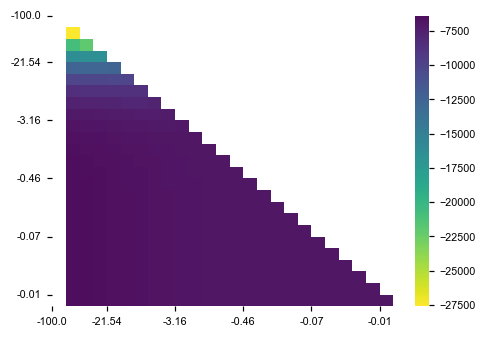

In [1661]:
seaborn.heatmap(dub_agefreq,alpha=0.95,cmap='viridis_r',mask=mask,norm=colors.Normalize())
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))

### What if there was only one $\gamma$ in the data? 

In [1651]:
samepredsonlyfreq = np.zeros((len(gamma),2))
samepredsagefreq = np.zeros((len(gamma),2))
for itg, trueg in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg)),0:3]

    newdat = newdf1.loc[newdf1['al']>0,:].to_numpy()

    # dub_onlyfreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
    # dub_agefreq = np.zeros((len(gamma),len(gamma))) # need a 2d search

    for ig1, g1 in enumerate(gamma):
        for ig2, g2 in enumerate(gamma[0:(ig1+1)]):
            dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,0], N=2500)) + 0.5*np.exp(get_lp_xl(g2, newdat[:,0], N=2500))))
    
            dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0])) + 0.5*np.exp(get_lp_alxl(g2, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g2, newdat[:,0]))))

    samepredsonlyfreq[itg,:] = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))
    samepredsagefreq[itg,:] = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))

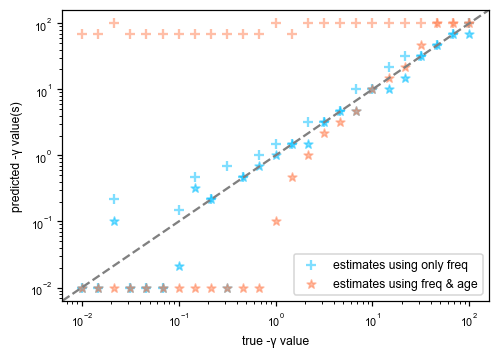

In [1655]:
## plotting the above results
plt.scatter(-gamma, -samepredsonlyfreq[:,0], color='deepskyblue', marker='*', alpha=0.5)
plt.scatter(-gamma, -samepredsonlyfreq[:,1], color='deepskyblue', marker='+', label='estimates using only freq', alpha=0.5)
plt.scatter(-gamma, -samepredsagefreq[:,0], color='coral', marker='*', label='estimates using freq & age', alpha=0.5)
plt.scatter(-gamma, -samepredsagefreq[:,1], color='coral', marker='+', alpha=0.5)
plt.xlabel('true -γ value'); plt.ylabel('predicted -γ value(s)'); plt.loglog()
plt.axline((0.01,0.01),(100,100),color='grey',ls='--'); plt.legend()

### Template code to compute difference in $\gamma$ given set of data

Here, I will run the mechanism to compute the probability of a significant difference in selection coefficients is detected given a set of large data i.e., 2000 data points and I will resample 25 times to obtain smaller datasets of 500. 

In [1482]:
# num_sims is number of reps to run to calculate prob
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_freq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.
    sin_onlyfreq = np.empty(len(gamma))
    dub_onlyfreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newnewdat[:,0]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_onlyfreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g, newnewdat[:,0])) + 0.5*np.exp(get_lp_xl(g2, newnewdat[:,0]))))

        estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

        estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
        estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]

        lambfreq = 2.*(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq] - sin_onlyfreq[gamma==estgonlyfreq])

        if(chi2.sf(lambfreq, 1)<thresh):
            prob += 1.

    return prob/num_sims

In [1538]:
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_agefreq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.

    sin_agefreq = np.empty(len(gamma))

    dub_agefreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_agefreq[ig] = np.sum(get_lp_alxl(g, newnewdat[:,0], newnewdat[:,2], n=100) + get_lp_xl(g, newnewdat[:,0]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_agefreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,0], newnewdat[:,2], n=100) + get_lp_xl(g, newnewdat[:,0])) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,0], newnewdat[:,2], n=100) + get_lp_xl(g2, newnewdat[:,0]))))

        estgagefreq = gamma[np.nanargmax(sin_agefreq)]        

        estg1agefreq = gamma[np.unravel_index(np.nanargmax(dub_agefreq[~mask]), dub_agefreq.shape)[0]]
        estg2agefreq = gamma[np.unravel_index(np.nanargmax(dub_agefreq[~mask]), dub_agefreq.shape)[1]]

        lambagefreq = 2.*(dub_agefreq[gamma==estg1agefreq,gamma==estg2agefreq] - sin_agefreq[gamma==estgagefreq])

        if(chi2.sf(lambagefreq, 1)<thresh):
            prob += 1.

    return prob/num_sims

In [1520]:
gamma

array([-1.000000e+02, -6.812921e+01, -4.641589e+01, -3.162278e+01,
       -2.154435e+01, -1.467799e+01, -1.000000e+01, -6.812921e+00,
       -4.641589e+00, -3.162278e+00, -2.154435e+00, -1.467799e+00,
       -1.000000e+00, -6.812921e-01, -4.641589e-01, -3.162278e-01,
       -2.154435e-01, -1.467799e-01, -1.000000e-01, -6.812921e-02,
       -4.641589e-02, -3.162278e-02, -2.154435e-02, -1.467799e-02,
       -1.000000e-02])

In [1620]:
## sample with specific combinations of gamma
trueg1 = -1.
trueg2 = -1.
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])

newdat = newdf1.loc[newdf1['al']>0,:].to_numpy()
# print(resample_calculateprob_freq(newdat, gamma, num_sims=16, num_samps=800))
# print(resample_calculateprob_agefreq(newdat, gamma, num_sims=16, num_samps=800))

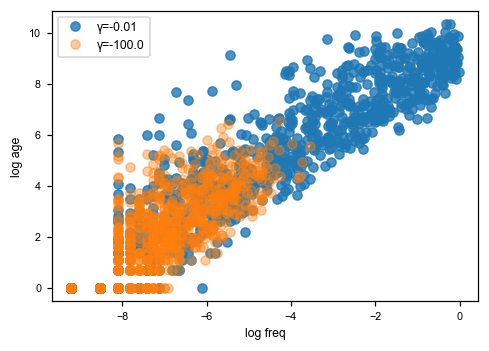

In [1527]:
plt.plot(np.log(newdat[0:1000,0]),np.log(newdat[0:1000,2]),'o',label='γ={}'.format(newdat[0,1]),alpha=0.8)
plt.plot(np.log(newdat[1000:2000,0]),np.log(newdat[1000:2000,2]),'o',label='γ={}'.format(newdat[1000,1]),alpha=0.4)
plt.xlabel('log freq')
plt.ylabel('log age')
plt.legend() 

In [1617]:
diffgamma =  list(it.combinations(gamma[0::3], 2)) # [(-0.01, x) for x in gamma[:-1]]
diffprobs = np.zeros((len(diffgamma),2))
for ig, g in enumerate(diffgamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g[0])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==g[1])),:])
    # newdf1 = newdf1.sample(frac=1)
    newdat = newdf1.to_numpy()
    diffprobs[ig,0] = resample_calculateprob_freq(newdat, gamma, num_samps=500)
    diffprobs[ig,1] = resample_calculateprob_agefreq(newdat, gamma, num_samps=500)

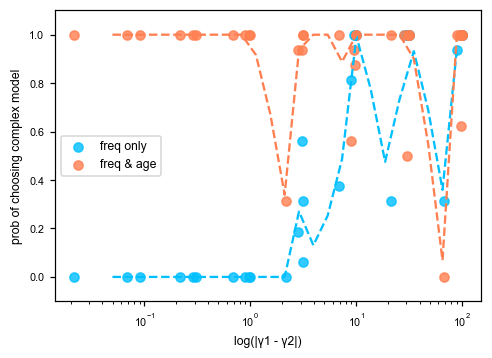

In [1619]:
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], color='deepskyblue', alpha=0.8, label='freq only')
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], color='coral', alpha=0.8, label='freq & age')
ginterp = np.logspace(-3,4.5,base=np.exp(1),num=25)
fit = scipy.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='deepskyblue')
fit = scipy.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='coral')
plt.ylim((-0.1,1.1))
plt.xscale('log')
plt.xlabel('log(|γ1 - γ2|)')
plt.ylabel('prob of choosing complex model')
plt.legend()

In [1542]:
# diffgamma
[diffgamma, diffprobs]

[[(-100.0, -21.54435),
  (-100.0, -4.641589),
  (-100.0, -1.0),
  (-100.0, -0.2154435),
  (-100.0, -0.04641589),
  (-100.0, -0.01),
  (-21.54435, -4.641589),
  (-21.54435, -1.0),
  (-21.54435, -0.2154435),
  (-21.54435, -0.04641589),
  (-21.54435, -0.01),
  (-4.641589, -1.0),
  (-4.641589, -0.2154435),
  (-4.641589, -0.04641589),
  (-4.641589, -0.01),
  (-1.0, -0.2154435),
  (-1.0, -0.04641589),
  (-1.0, -0.01),
  (-0.2154435, -0.04641589),
  (-0.2154435, -0.01),
  (-0.04641589, -0.01)],
 array([[0.8125, 1.    ],
        [1.    , 1.    ],
        [1.    , 0.8125],
        [1.    , 0.875 ],
        [1.    , 1.    ],
        [1.    , 1.    ],
        [0.9375, 1.    ],
        [1.    , 0.5625],
        [1.    , 1.    ],
        [1.    , 1.    ],
        [1.    , 1.    ],
        [0.    , 0.5   ],
        [0.5   , 0.875 ],
        [0.625 , 1.    ],
        [0.5   , 1.    ],
        [0.    , 1.    ],
        [0.    , 1.    ],
        [0.    , 1.    ],
        [0.    , 1.    ],
        [0.  